## 모델선정 1
- 팀 병합을 위해 DACON에 최초 제출하기 위한 결과물 생성용으로 첫 모델들을 생성하였습니다
- 로지스틱 회귀, MLP(Multilayer Perceptron)를 이용하여 첫 학습을 시도하였습니다
- 모델 학습을 위해 투입된 데이터는 KoBERT가 제공하는 Pre-trained된 모델에 원자료 데이터를 그대로 넣어서 출력되는 Tensor를 이용하였습니다.
    - 즉 본 데이터셋을 학습하지 않고 이전에 KoBERT가 이용한 wiki, 뉴스 데이터를 바탕으로 학습된 모델이 출력하는 현 데이터셋의 output을 말합니다

<br >

## 발견한 점
- 두 모델을 이용하여 DACON에 제출하여 Accuracy를 확인한 결과 모두 0.5 수준에 머물렀습니다
    - 훈련 데이터셋을 이용한 학습의 경우에는 정확도가 90%를 넘었으나 테스트 데이터셋에서는 랜덤한 수준의 분류결과가 도출되었습니다
    - 즉 모델이 훈련데이터를 과적합한 것으로 파악됩니다
- 위와 같은 성능이 나온것에 2가지 원인이 있을것으로 파악하였습니다
    - 로지스틱 회귀, MLP가 본 task에 적절하지 않은 모델인 것으로 파악됩니다
    - 이는 학습되지 않은 데이터셋에 의한 요인도 존재하나 해당 데이터셋의 데이터마다 **Padding길이를 64차원**으로 밖에 표현하지 못하는 것에 기인한다고 할 수 있습니다
- 따라서 주어진 데이터셋을 적절히 학습하여 좋은 성능을 보일 수 있는 다른 모델을 찾을 필요성을 더욱 통감하였습니다

In [ ]:
import os, sys
from google.colab import drive

#내 구글드라이브 디렉토리 설정
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 package_collection 폴더에 패키지 저장
#매 실행마다 이 코드를 재실행해야 해당 디렉토리에 있는 패키지를 사용할 수 있음
os.symlink('/content/drive/MyDrive/Colab Notebooks/py_env', my_path)
sys.path.insert(0, my_path)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#로지스틱 회귀 이용 분류해보기

#데이터 불러오기
import pandas as pd
import numpy as np
import torch

train_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/train_tokenized.pkl')

In [ ]:
train_df.head()

,n_id,date,title,content,ord,info,clean_content,tokenized_cont
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,이데일리 MARKETPOINT 현재 코스닥 기관 억 순매도,"[[tensor(3661), tensor(671), tensor(267), tens..."
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,실적기반 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개,"[[tensor(3047), tensor(5561), tensor(6286), te..."
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,하이스탁론 선취수수료 없는 최저금리 상품 출시,"[[tensor(4942), tensor(6664), tensor(7589), te..."
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,종합 경제정보 미디어 이데일리 무단전재 재배포 금지,"[[tensor(4203), tensor(972), tensor(7229), ten..."
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,전국적인 소비 붐 조성에 기여할 예정,"[[tensor(4014), tensor(7206), tensor(2832), te..."


In [ ]:
tok_cont_torch = train_df['tokenized_cont'].values

In [ ]:
tok_cont_torch = torch.LongTensor([tok_cont_torch])

TypeError: ignored

In [ ]:
type(tok_cont_torch) 
  #객체 형태 자체가 numpy, 하지만 내부 원소들은 모두 torch 데이터 형태

numpy.ndarray

In [ ]:
tok_cont_torch[0].shape

torch.Size([1, 16])

In [ ]:
tok_cont_torch[0]

tensor([[3661,  671,  267,  307,  282,  351,  333,  329,  302,  351, 5064, 4671,
         1261,  517, 6858, 2914]])

In [ ]:
#새로운 troch 객체를 만들어서 그 안에 word_index들을 담기 -> torchtext의 iterator를 이용하면 굳이 핀 토치를 만들필요 없음
#그 전에 문장길이가 과도하게 긴 행들을 제거해야 함
#패딩된 단어들은 정수인덱싱 1 값을 가진다. -> 이를 매핑할 방법을 고려해야 함

train_df.shape #11만 8745개의 데이터로 구성

(118745, 8)

In [ ]:
#토크나이저 불러오기
import torch
from kobert.utils import get_tokenizer
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer

tok_path = get_tokenizer()
sp  = SentencepieceTokenizer(tok_path)

[██████████████████████████████████████████████████]


In [ ]:
from kobert.pytorch_kobert import get_pytorch_kobert_model #시간 5 ~ 10분 소요
device = torch.device('cuda') #gpu를 사용하기 위해 선언

bertmodel, vocab = get_pytorch_kobert_model(ctx = device)

using cached model
using cached model


In [ ]:
tok_cont_torch_lt = tok_cont_torch.tolist()

In [ ]:
new_cont_torch = torch.LongTensor(tok_cont_torch_lt)
  #리스트로 변환했지만 텐서형태로 변환이 안됨
  #길이가 달라서 그럴수도 있는듯

ValueError: ignored

In [ ]:
#해야 할 것
#패딩 기준 선정 -> 어떤 문장 길이까지 수용할 것인지

In [ ]:
sent_size = train_df['tokenized_cont'].apply(lambda x: x.shape[1])

In [ ]:
sent_size.describe()

count    118745.000000
mean         23.136831
std          18.225367
min           0.000000
25%          12.000000
50%          18.000000
75%          29.000000
max        1675.000000
Name: tokenized_cont, dtype: float64

In [ ]:
sent_size.values[sent_size.values.argsort()[::-1]][:200] #200개 까지 문장이 11개 있으므로 이를 제거하고 시도

array([1675, 1289, 1080,  807,  538,  466,  450,  413,  393,  384,  358,
        351,  332,  286,  285,  285,  284,  283,  279,  276,  275,  275,
        275,  273,  273,  270,  268,  259,  235,  231,  229,  225,  212,
        207,  205,  205,  204,  204,  203,  200,  196,  193,  192,  190,
        188,  185,  184,  183,  182,  181,  180,  180,  176,  169,  169,
        169,  169,  169,  169,  169,  169,  169,  168,  167,  167,  163,
        163,  163,  162,  162,  162,  162,  160,  160,  160,  158,  158,
        158,  158,  158,  157,  157,  157,  156,  156,  156,  156,  155,
        155,  152,  152,  152,  151,  149,  149,  148,  147,  147,  146,
        146,  145,  145,  145,  145,  145,  144,  143,  142,  142,  142,
        142,  142,  140,  140,  140,  139,  139,  139,  139,  139,  139,
        139,  139,  138,  137,  137,  137,  137,  137,  137,  137,  136,
        135,  134,  134,  133,  133,  133,  132,  132,  132,  132,  131,
        131,  131,  130,  130,  129,  129,  129,  1

In [ ]:
#패딩길이 사전에 조절하지 않고 해보기
from torchtext.data import TabularDataset
from torchtext import data

In [ ]:
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize= sp, 
                  lower=True,
                  batch_first=True)

In [ ]:
#tabularDataset이 데이터프레임 파일을 받지 못해서 txt파일을 이용하여 작업을 해야함

train_df['clean_content'].to_csv('/content/drive/MyDrive/dacon/train_c_cont.txt', index = False, header = False ,sep = '\t')

In [ ]:
#torch가 인식할 수 있는 데이터셋 생성
train_data = TabularDataset(path = '/content/drive/MyDrive/dacon/train_c_cont.txt',
                            format = 'tsv',
                            fields = [('text', TEXT)])

In [ ]:
TEXT.build_vocab(train_data)

In [ ]:
from torchtext.data import Iterator
device = torch.device('cuda')

train_loader = Iterator(train_data,
                        batch_size = 100,
                        device = device,
                        repeat = False)

In [ ]:
for batch in train_loader:
    break
print(batch.text)
  #vocab가 우리가 이미 가지고 있는 정수인덱싱과 다르게 인덱싱됨
  #기존에 가지고 있는 단어사전을 이용할 수 있는 방법이 필요함

tensor([[  50,  185,   45,  ...,    1,    1,    1],
        [ 284,   23,  211,  ...,    1,    1,    1],
        [ 246,    6,  231,  ...,    1,    1,    1],
        ...,
        [2160, 5099,    6,  ...,    1,    1,    1],
        [ 645,   59, 1070,  ...,    1,    1,    1],
        [ 451,  633,   94,  ...,    1,    1,    1]], device='cuda:0')


In [ ]:
batch.text.shape 
  #패딩을 알아서 73개 단어까지 수행함

torch.Size([100, 73])

## 12.06 추가 작업내용
- 기존에 tokenize_and_mapping 함수 return부를 torch.tensor로 하지 않고 ndarray형식으로 하여서 변환해보기


In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/train_tokenized.pkl')
train_df.head()

,n_id,date,title,content,ord,info,clean_content,tokenized_cont
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,이데일리 MARKETPOINT 현재 코스닥 기관 억 순매도,"[[tensor(3661), tensor(671), tensor(267), tens..."
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,실적기반 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개,"[[tensor(3047), tensor(5561), tensor(6286), te..."
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,하이스탁론 선취수수료 없는 최저금리 상품 출시,"[[tensor(4942), tensor(6664), tensor(7589), te..."
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,종합 경제정보 미디어 이데일리 무단전재 재배포 금지,"[[tensor(4203), tensor(972), tensor(7229), ten..."
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,전국적인 소비 붐 조성에 기여할 예정,"[[tensor(4014), tensor(7206), tensor(2832), te..."


In [ ]:
word_to_id = vocab.token_to_idx
id_to_word = vocab.idx_to_token

In [ ]:
def tokenize_and_mapping(sent_tokenizer, sentence, word_to_id):

  temp = []
  corpus = sent_tokenizer(sentence)

  for word in corpus:
    temp.append(word_to_id[word])

  return np.array([temp])

In [ ]:
train_df['tokenized_cont'] = train_df['clean_content'].apply(lambda x: tokenize_and_mapping(sp, x, word_to_id))

In [ ]:
train_df.head()

,n_id,date,title,content,ord,info,clean_content,tokenized_cont
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,이데일리 MARKETPOINT 현재 코스닥 기관 억 순매도,"[3661, 671, 267, 307, 282, 351, 333, 329, 302,..."
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,실적기반 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개,"[3047, 5561, 6286, 3990, 5330, 6896, 1986, 735..."
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,하이스탁론 선취수수료 없는 최저금리 상품 출시,"[4942, 6664, 7589, 6084, 2734, 7476, 6636, 327..."
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,종합 경제정보 미디어 이데일리 무단전재 재배포 금지,"[4203, 972, 7229, 2154, 3661, 2095, 5788, 7207..."
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,전국적인 소비 붐 조성에 기여할 예정,"[4014, 7206, 2832, 517, 6426, 4177, 6896, 1295..."


In [ ]:
test_val = list(train_df['tokenized_cont'].values)

In [ ]:
test_long_val = torch.LongTensor(test_val[0])

In [ ]:
test_long_val

tensor([[3661,  671,  267,  307,  282,  351,  333,  329,  302,  351, 5064, 4671,
         1261,  517, 6858, 2914]])

In [ ]:
bertmodel(test_long_val)[0].shape

torch.Size([1, 16, 768])

In [ ]:
#정수 인덱싱 텐서를 만드는 방법
#가장 긴 문장을 바탕으로 1로 채워진 베이스 행렬을 만든 후
#그 베이스 행렬에 하나씩 쌓기

train_df.iloc[37707, -1].shape

(1, 1675)

In [ ]:
train_df.shape[0]

118745

In [ ]:
base_torch = torch.ones((118745, 1675), dtype = torch.long)

In [ ]:
base_torch[0, :test_long_val.shape[1]] = test_long_val

In [ ]:
len(test_val)

118745

In [ ]:
#리스트에서 하나씩 array를 꺼내와서 텐서로 만들고
#그 텐서를 base텐서의 행에 하나씩 끼워넣는 작업을 실시


for i, array in enumerate(test_val):
  temp = None
  long_val = torch.LongTensor(array)
  base_torch[i, :long_val.shape[1]] = long_val

In [ ]:
base_torch

tensor([[3661,  671,  267,  ...,    1,    1,    1],
        [3047, 5561, 6286,  ...,    1,    1,    1],
        [4942, 6664, 7589,  ...,    1,    1,    1],
        ...,
        [ 517, 5981, 5981,  ...,    1,    1,    1],
        [4958,  694,  553,  ...,    1,    1,    1],
        [4958,  694,  553,  ...,    1,    1,    1]])

In [ ]:
#해당 텐서를 저장하기
torch.save(base_torch, '/content/drive/MyDrive/dacon/padded_index.pt')

In [ ]:
#텐서 불러오기
base_torch = torch.load('/content/drive/MyDrive/dacon/padded_index.pt')

In [ ]:
#100개까지 불러왔을 때 용량을 얼마나 차지할지 실험
test_embedded = bertmodel(base_torch[:100,:])[0]
  #최대 512길이까지 밖에 사용을 못함

RuntimeError: ignored

In [ ]:
#128단어 까지 문장을 줄이기
base_trunc_torch = base_torch[:, :128]

In [ ]:
base_trunc_torch.shape

torch.Size([118745, 128])

In [ ]:
test_embedded = bertmodel(base_trunc_torch[:100,:])[0]
  #램 부족 현상으로 세션이 다운되었음;;

In [ ]:
#64 단어까지 문장을 줄이기
base_trunc_torch = base_torch[:, :64]

In [ ]:
base_trunc_torch.shape

torch.Size([118745, 64])

In [ ]:
test_embedded = bertmodel(base_trunc_torch[:50,:])[0]
  #64차원의 데이터를 50개 까지 가져와도 램 부족현상은 일어나지 않음
  #따라서 배치 사이즈를 64, 차원도 64로 설정하는 것이 좋을듯

In [ ]:
#target tensor 생성
target_torch = torch.LongTensor(train_df['info'].values.reshape(-1,1))

In [ ]:
target_torch.shape

torch.Size([118745, 1])

In [ ]:
#로지스틱 회귀 모델 구현
#파라미터 선언

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

num_epochs = 5
batch_size = 64
input_dim = 768
output_dim = 1

#모델 클래스 만들기
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [ ]:
#모델 선언
model = LogisticRegression(input_dim, output_dim).to(device)

#손실함수 선언
cost = nn.CrossEntropyLoss()

#최적화 함수 선언
optimizer = optim.Adam(model.parameters())

In [ ]:
#data_loader 만들기
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader

datasets = TensorDataset(base_trunc_torch, target_torch)

train_dataloader = DataLoader(datasets, batch_size = batch_size, shuffle = True)

In [ ]:
len(train_dataloader)

1856

In [ ]:
#gpu로 로지스틱회귀 학습하기

for epoch in range(num_epochs):

  for i, samples in enumerate(train_dataloader):
    x_train, y_train = samples[0].to(device), samples[1].to(device)

    #임베딩된 벡터들 불러오기
    embedded_mat = bertmodel(x_train)[0]

    #예측
    pred = model(embedded_mat)

    #손실구하기
    loss = cost(pred, y_train)

    #역전파 수행
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch {:4d} / {} Batch {} / {} CostL {:.6f}'.format(epoch, num_epochs, i+1, len(train_dataloader), loss.item()))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch    2 / 5 Batch 569 / 1856 CostL 2.192917
Epoch    2 / 5 Batch 570 / 1856 CostL 2.186681
Epoch    2 / 5 Batch 571 / 1856 CostL 2.670530
Epoch    2 / 5 Batch 572 / 1856 CostL 2.951430
Epoch    2 / 5 Batch 573 / 1856 CostL 2.199193
Epoch    2 / 5 Batch 574 / 1856 CostL 2.503573
Epoch    2 / 5 Batch 575 / 1856 CostL 2.658930
Epoch    2 / 5 Batch 576 / 1856 CostL 2.578691
Epoch    2 / 5 Batch 577 / 1856 CostL 2.847527
Epoch    2 / 5 Batch 578 / 1856 CostL 2.513560
Epoch    2 / 5 Batch 579 / 1856 CostL 2.463626
Epoch    2 / 5 Batch 580 / 1856 CostL 2.505350
Epoch    2 / 5 Batch 581 / 1856 CostL 2.770753
Epoch    2 / 5 Batch 582 / 1856 CostL 2.637225
Epoch    2 / 5 Batch 583 / 1856 CostL 2.517071
Epoch    2 / 5 Batch 584 / 1856 CostL 2.342143
Epoch    2 / 5 Batch 585 / 1856 CostL 2.534139
Epoch    2 / 5 Batch 586 / 1856 CostL 2.520952
Epoch    2 / 5 Batch 587 / 1856 CostL 2.631839
Epoch    2 / 5 Batch 588 / 1856 CostL 2.314530
Epoch    2 / 5 Batch 589

In [ ]:
#학습결과 손실이 1.8 ~ 2.5로 수렴하는 양상
#모델 저장하기

torch.save(model.state_dict(), '/content/drive/MyDrive/dacon/lr_net.pth')

In [ ]:
_, predicted = torch.max(pred.to('cpu').data, 1)

correct = (predicted == y_train.to('cpu')).sum()

In [ ]:
train_df.shape[0]

118745

In [ ]:
100 * (correct / 25)

tensor(56.)

In [ ]:
#제대로 학습되지 못함
#MLP 형식으로 분류를 수행해보기
model = nn.Sequential(
    nn.Linear(768, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
).to(device)

cost = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

In [ ]:
#3번의 학습만 수행해보기
num_epochs = 3

losses = []

for epoch in range(num_epochs):

  for i, samples in enumerate(train_dataloader):
    x_train, y_train = samples[0].to(device), samples[1].to(device)

    #임베딩된 벡터들 불러오기
    embedded_mat = bertmodel(x_train)[0]

    #예측
    pred = model(embedded_mat)

    #손실구하기
    loss = cost(pred, y_train)

    #역전파 수행
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) %100 == 0:
      losses.append(loss.item())
      print('Epoch {:4d} / {} Batch {} / {} CostL {:.6f}'.format(epoch + 1, num_epochs, i+1, len(train_dataloader), loss.item()))

Epoch    1 / 3 Batch 100 / 1856 CostL 1.785141
Epoch    1 / 3 Batch 200 / 1856 CostL 1.674836
Epoch    1 / 3 Batch 300 / 1856 CostL 1.342435
Epoch    1 / 3 Batch 400 / 1856 CostL 0.841026
Epoch    1 / 3 Batch 500 / 1856 CostL 0.949699
Epoch    1 / 3 Batch 600 / 1856 CostL 1.430205
Epoch    1 / 3 Batch 700 / 1856 CostL 0.698399
Epoch    1 / 3 Batch 800 / 1856 CostL 0.738478
Epoch    1 / 3 Batch 900 / 1856 CostL 0.438507
Epoch    1 / 3 Batch 1000 / 1856 CostL 0.408813
Epoch    1 / 3 Batch 1100 / 1856 CostL 0.441680
Epoch    1 / 3 Batch 1200 / 1856 CostL 0.548530
Epoch    1 / 3 Batch 1300 / 1856 CostL 0.397381
Epoch    1 / 3 Batch 1400 / 1856 CostL 0.406733
Epoch    1 / 3 Batch 1500 / 1856 CostL 0.520287
Epoch    1 / 3 Batch 1600 / 1856 CostL 0.288251
Epoch    1 / 3 Batch 1700 / 1856 CostL 0.604531
Epoch    1 / 3 Batch 1800 / 1856 CostL 0.326080
Epoch    2 / 3 Batch 100 / 1856 CostL 0.255159
Epoch    2 / 3 Batch 200 / 1856 CostL 0.449903
Epoch    2 / 3 Batch 300 / 1856 CostL 0.333597
Epoc

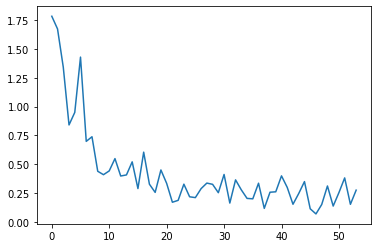

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [ ]:
result = torch.max(pred.to('cpu').data, 1)[1]

In [ ]:
accuracy = sum(y_train.to('cpu').data == result) / 25
print(accuracy) #미니배치 데이터에 대해서 88%의 정확도가 보임

tensor([0.8800])


In [ ]:
#모델 저장하기
torch.save(model.state_dict(), '/content/drive/MyDrive/dacon/mlp_net.pth')

In [ ]:
#모든 예측값들을 얻기

model.eval()

y_true = torch.tensor([], dtype = torch.long, device = device)
all_outputs = torch.tensor([], device=device)

with torch.no_grad():
  for samples in train_dataloader:

    inputs = samples[0].to(device)
    labels = samples[1].to(device)

    embedded_inputs = bertmodel(inputs)[0]

    outputs = model(embedded_inputs)

    all_outputs = torch.cat((all_outputs, outputs), dim =0)
    y_true = torch.cat((y_true, labels), dim = 0)

y_preds = torch.max(all_outputs, 1)[1]

In [ ]:
#np 객체로 바꿔주기
y_preds = y_preds.to('cpu').numpy()
y_true = y_true.to('cpu').numpy()

In [ ]:
print((sum(y_preds == y_true) / y_preds.shape[0]) * 100)
  #훈련 데이트세트에 대하여 92%의 정확도를 보임

[92.73148343]


In [ ]:
#test 데이터셋을 이용하여 제출하기 
test_df = pd.read_csv('/content/drive/MyDrive/dacon/news_test.csv')
test_sub_df = pd.read_csv('/content/drive/MyDrive/dacon/sample_submission.csv')
test_df.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [ ]:
test_df.drop(['n_id'], axis = 1, inplace = True)

test_df_merged = test_df.merge(test_sub_df, how = 'inner', on = 'id')

In [ ]:
test_df_merged.isnull().sum() #결측치 없이 제대로 input되었음

date       0
title      0
content    0
ord        0
id         0
info       0
dtype: int64

In [ ]:
del(test_sub_df)

In [ ]:
#문장 전처리 및 토큰화
import re

stopwords_kr = pd.read_csv('/content/drive/MyDrive/dacon/stopwords_kr.txt',sep = '\n', header = None)
stop_kr_list = list(stopwords_kr.iloc[:,0])

url_with_https = re.compile(r'(https?:\/\/){1,}([\w.\/%-]+){1,}')
rm_email = re.compile(r'([a-zA-Z0-9\.\_]+)@([\w\.]+){1,}')
useless_words = re.compile(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]+')
rm_num = re.compile(r'(\d+\.?\,?\d+)+')

#지난 여름 자율프로젝트에서 사용했던 텍스트 전처리 방식 가져옴
def clean_kor_text(kor_text):
    text = url_with_https.sub('',kor_text)
    text = rm_email.sub('', text)
    text = useless_words.sub('',text)
    text = rm_num.sub('',text)
    text = ' '.join(word for word in text.split() if word not in stop_kr_list)
    return text

def tokenize_and_mapping(sent_tokenizer, sentence, word_to_id):

  temp = []
  corpus = sent_tokenizer(sentence)

  for word in corpus:
    temp.append(word_to_id[word])

  return np.array([temp])

In [ ]:
#컨텐츠 내용 전처리 및 정수인덱싱
test_df_merged['clean_cont'] = test_df_merged['content'].apply(clean_kor_text)
test_df_merged['cont_tokenized'] = test_df_merged['clean_cont'].apply(lambda x: tokenize_and_mapping(sp, x, word_to_id))

In [ ]:
test_df_merged.head()

,date,title,content,ord,id,info,clean_cont,cont_tokenized
0,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,0,마이크로 LED TV 장비 양산 돌입 전방업체 투자 확대로 본업도 호조연일 신고가,"[[1907, 7096, 7565, 6079, 517, 312, 694, 3961,..."
1,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,0,이데일리 김대웅 기자 반도체 장비 업체 코세스의 기술력이 마이크로 발광다이오드LED...,"[[3661, 1316, 5808, 7017, 517, 5580, 2209, 396..."
2,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,0,최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,"[[4525, 1690, 3269, 5468, 867, 6116, 2006, 543..."
3,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,0,TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,"[[694, 6116, 4916, 5907, 6079, 3451, 1907, 709..."
4,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,0,코세스는 반도체 장비를 제조 판매하는 업체로 지난 코스닥 시장에 상장했고 창업주인 ...,"[[4665, 6579, 6666, 2209, 3961, 6116, 4151, 48..."


In [ ]:
test_df_merged.shape

(142565, 8)

In [ ]:
#모든 정수인덱싱을 담은 tensor 생성
tokenized_ind_list = list(test_df_merged['cont_tokenized'].values)
base_torch = torch.ones((test_df_merged.shape[0], 1575), dtype = torch.long)

for i, array in enumerate(tokenized_ind_list):
  long_val = torch.LongTensor(array)
  base_torch[i, :long_val.shape[1]] = long_val

In [ ]:
trunc_torch = base_torch[:, :64]
trunc_torch

tensor([[1907, 7096, 7565,  ...,    1,    1,    1],
        [3661, 1316, 5808,  ...,    1,    1,    1],
        [4525, 1690, 3269,  ...,    1,    1,    1],
        ...,
        [ 517, 5981, 5981,  ...,    1,    1,    1],
        [4958,  694,  553,  ...,    1,    1,    1],
        [4958,  694,  553,  ...,    1,    1,    1]])

In [ ]:
trunc_torch.shape

torch.Size([142565, 64])

In [ ]:
#dataset, Dataloader 만들기
test_datasets = TensorDataset(trunc_torch)

test_dataloader = DataLoader(test_datasets, batch_size = batch_size, shuffle = True) #동일하게 64 배치사이즈로 설정

In [ ]:
#테스트 데이터의 예측값 산출하기
model.eval()

test_preds = torch.tensor([], device = device)

with torch.no_grad():
  for sample in test_dataloader:

    inputs = sample[0].to(device)

    embedded_inputs = bertmodel(inputs)[0]

    outputs = model(embedded_inputs)

    test_preds = torch.cat((test_preds, outputs), dim =0)

y_preds = torch.max(test_preds, 1)[1]

In [ ]:
y_preds.shape

torch.Size([142565, 1])

In [ ]:
test_sub_df = pd.read_csv('/content/drive/MyDrive/dacon/sample_submission.csv')
test_sub_df.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [ ]:
test_sub_df['info'] = y_preds.to('cpu').numpy()

In [ ]:
test_sub_df

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,1
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,1
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [ ]:
test_sub_df.to_csv('/content/drive/MyDrive/dacon/mh_first_submission.csv', index = False)